In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from src.utils import plot_categorical_features
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder

In [2]:
# Loading data into pandas dataframe
BASE_PATH = os.path.dirname(os.getcwd())
if 'data' in os.listdir(BASE_PATH):
    RAW_DATA_PATH = os.path.join(BASE_PATH, 'data', 'raw')
    income_data = pd.read_csv(os.path.join(RAW_DATA_PATH, 'income_evaluation.csv'))
income_data.columns = income_data.columns.str.strip()
temp_df = income_data.select_dtypes(include=['object']).apply(lambda x: x.str.strip())
income_data.drop(temp_df.columns, axis=1, inplace=True)
income_data = pd.concat([income_data, temp_df], axis=1)

del(temp_df)

income_data.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,39,77516,13,2174,0,40,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,50,83311,13,0,0,13,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,38,215646,9,0,0,40,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,53,234721,7,0,0,40,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,28,338409,13,0,0,40,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [3]:
income_data.attrs['source'] = 'Kaggle'
income_data.attrs['url'] = 'https://www.kaggle.com/datasets/lodetomasi1995/income-classification'
income_data.attrs['problem'] = 'Income Classification'
income_data.attrs['published by'] = 'Lorenzo De Tomasi'

In [4]:
income_data.attrs

{'source': 'Kaggle',
 'url': 'https://www.kaggle.com/datasets/lodetomasi1995/income-classification',
 'problem': 'Income Classification',
 'published by': 'Lorenzo De Tomasi'}

In [5]:
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   fnlwgt          32561 non-null  int64 
 2   education-num   32561 non-null  int64 
 3   capital-gain    32561 non-null  int64 
 4   capital-loss    32561 non-null  int64 
 5   hours-per-week  32561 non-null  int64 
 6   workclass       32561 non-null  object
 7   education       32561 non-null  object
 8   marital-status  32561 non-null  object
 9   occupation      32561 non-null  object
 10  relationship    32561 non-null  object
 11  race            32561 non-null  object
 12  sex             32561 non-null  object
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
income_data.isna().sum()

age               0
fnlwgt            0
education-num     0
capital-gain      0
capital-loss      0
hours-per-week    0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
native-country    0
income            0
dtype: int64

In [6]:
income_data.dtypes.value_counts()

object    9
int64     6
Name: count, dtype: int64

## Splitting the problem into smaller sub-problems according to there datatypes

In [24]:

income_data_obj = income_data.select_dtypes(include=['object']).copy()
income_data_int = income_data.select_dtypes(exclude=['object']).copy()

### Start by treating with objective-type attributes

In [43]:
income_data_obj.head(3)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K


In [25]:
income_data_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       32561 non-null  object
 1   education       32561 non-null  object
 2   marital-status  32561 non-null  object
 3   occupation      32561 non-null  object
 4   relationship    32561 non-null  object
 5   race            32561 non-null  object
 6   sex             32561 non-null  object
 7   native-country  32561 non-null  object
 8   income          32561 non-null  object
dtypes: object(9)
memory usage: 2.2+ MB


In [60]:
# obj_attribute_values = {column: income_data_obj[column].unique().tolist() for column in income_data_obj.columns}
# obj_attribute_values

# Calculate Odd Ratios
'''for feature in income_data_obj.drop(columns=[' income']).columns:
    cross_tab = pd.crosstab(income_data_obj[feature], income_data_obj[' income'], normalize='index')
    cross_tab['odds'] = cross_tab[' >50K'] / cross_tab[' <=50K']
    print(f"Odds Ratio for {feature}:\n", cross_tab[['odds']])'''
   
# Investigating that why there is a very strong correlation between 'relationship' and 'income' 
'''relationship_dist = income_data_obj.groupby(' relationship')[' income'].value_counts(normalize=True).unstack()
print(relationship_dist)
relationship_dist.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title("Income Distribution by Relationship")
plt.xlabel("Relationship")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.show()'''

'''
plot_type = 'count'
print(f"Invalid plot type: {plot_type}. Supported plot types are: {', '.join([func for func in dir(sns) if callable(getattr(sns, func))])}")
'''

In [46]:
pd.crosstab(income_data_obj['relationship'], income_data_obj['income'])

income,<=50K,>50K
relationship,,
Husband,7275,5918
Not-in-family,7449,856
Other-relative,944,37
Own-child,5001,67
Unmarried,3228,218
Wife,823,745


#### 1. Handling Missing Values

In [8]:
income_data_obj.applymap(lambda x: (x == ' ?') or (x == '?')).any()

workclass          True
education         False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
native-country     True
income            False
dtype: bool

In [9]:
print(
    income_data_obj[income_data_obj['workclass'] == '?']['workclass'].value_counts(),
    income_data_obj[income_data_obj['occupation'] == '?']['occupation'].value_counts(),
    income_data_obj[income_data_obj['native-country'] == '?']['native-country'].value_counts(),
    sep='\n\n'
    )

workclass
?    1836
Name: count, dtype: int64

occupation
?    1843
Name: count, dtype: int64

native-country
?    583
Name: count, dtype: int64


In [49]:
income_data_obj[income_data_obj['native-country'] == '?']

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
14,Private,Assoc-voc,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,?,>50K
38,Private,Some-college,Married-civ-spouse,Sales,Husband,White,Male,?,>50K
51,Private,HS-grad,Never-married,Other-service,Own-child,White,Female,?,<=50K
61,?,7th-8th,Married-spouse-absent,?,Not-in-family,White,Male,?,<=50K
93,Private,HS-grad,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,?,<=50K
...,...,...,...,...,...,...,...,...,...
32449,Self-emp-inc,Masters,Married-civ-spouse,Sales,Husband,White,Male,?,>50K
32469,Self-emp-inc,Doctorate,Never-married,Prof-specialty,Not-in-family,White,Female,?,<=50K
32492,Self-emp-not-inc,HS-grad,Divorced,Sales,Own-child,White,Male,?,<=50K
32510,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,?,>50K


In [50]:
# Attributes that share similer missing values in the rows
income_data_obj[
    (income_data_obj['workclass'] == '?') & (income_data_obj['occupation'] == '?')
    ]

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
27,?,Some-college,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,South,>50K
61,?,7th-8th,Married-spouse-absent,?,Not-in-family,White,Male,?,<=50K
69,?,Some-college,Never-married,?,Own-child,White,Male,United-States,<=50K
77,?,10th,Married-civ-spouse,?,Husband,White,Male,United-States,<=50K
106,?,10th,Never-married,?,Own-child,White,Female,United-States,<=50K
...,...,...,...,...,...,...,...,...,...
32530,?,Bachelors,Married-civ-spouse,?,Wife,White,Female,United-States,>50K
32531,?,Bachelors,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,United-States,<=50K
32539,?,Doctorate,Married-civ-spouse,?,Husband,White,Male,United-States,>50K
32541,?,HS-grad,Separated,?,Not-in-family,Black,Female,United-States,<=50K


In [51]:
# Attributes that are not share the similer missing valeus
income_data_obj[
    (income_data_obj['workclass'] != '?') & (income_data_obj['occupation'] == '?')
    ]

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
5361,Never-worked,10th,Never-married,?,Own-child,White,Male,United-States,<=50K
10845,Never-worked,7th-8th,Divorced,?,Not-in-family,White,Male,United-States,<=50K
14772,Never-worked,10th,Never-married,?,Own-child,White,Male,United-States,<=50K
20337,Never-worked,11th,Never-married,?,Own-child,White,Female,United-States,<=50K
23232,Never-worked,Some-college,Never-married,?,Own-child,Black,Male,United-States,<=50K
32304,Never-worked,HS-grad,Married-civ-spouse,?,Wife,Black,Female,United-States,<=50K
32314,Never-worked,Some-college,Never-married,?,Own-child,White,Male,United-States,<=50K


In [52]:
# 27 missing values in native-country that are overlap with workclass and occupation
income_data_obj[
    (income_data_obj['workclass'] == '?') & (income_data_obj['occupation'] == '?') & (income_data_obj['native-country'] == '?')
    ].head(5)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
61,?,7th-8th,Married-spouse-absent,?,Not-in-family,White,Male,?,<=50K
297,?,Masters,Married-civ-spouse,?,Wife,Asian-Pac-Islander,Female,?,<=50K
1152,?,Some-college,Never-married,?,Not-in-family,White,Male,?,<=50K
1676,?,HS-grad,Married-civ-spouse,?,Husband,White,Male,?,>50K
2513,?,HS-grad,Married-civ-spouse,?,Husband,White,Male,?,<=50K


In [26]:
# This is an inplace Function, make sure to consider it while running
income_data_obj.replace('?', 'Unknown', inplace=True)

In [27]:
income_data_obj[
    (income_data_obj['workclass'] == 'Unknown') & (income_data_obj['occupation'] == 'Unknown')
    ].head(4)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
27,Unknown,Some-college,Married-civ-spouse,Unknown,Husband,Asian-Pac-Islander,Male,South,>50K
61,Unknown,7th-8th,Married-spouse-absent,Unknown,Not-in-family,White,Male,Unknown,<=50K
69,Unknown,Some-college,Never-married,Unknown,Own-child,White,Male,United-States,<=50K
77,Unknown,10th,Married-civ-spouse,Unknown,Husband,White,Male,United-States,<=50K


#### 2. Analysis on Each Attributes

##### 1. Diversity & Varibility Analysis

In [124]:
income_data_obj.nunique()

workclass          9
education         16
marital-status     7
occupation        15
relationship       6
race               5
sex                2
native-country    42
income             2
dtype: int64

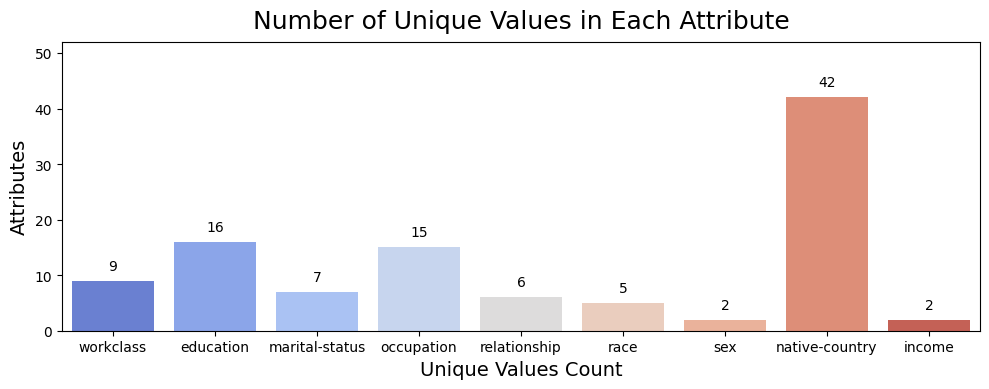

In [56]:
plt.figure(figsize=(10, 4))
sns.barplot(
    x=income_data_obj.nunique().index,
    y=income_data_obj.nunique().values,
    palette='coolwarm',
    hue=income_data_obj.nunique().index,
    dodge=False
)
plt.title('Number of Unique Values in Each Attribute', fontsize=18, pad=10)
plt.xlabel('Unique Values Count', fontsize=14)
plt.ylabel('Attributes', fontsize=14)
for i, v in enumerate(income_data_obj.nunique().values):
    plt.text(i, v + 2, str(v), color='black', ha='center')
plt.ylim(0, income_data_obj.nunique().max() + 10)
plt.tight_layout()
plt.show()

##### 2. Distribution Analysis

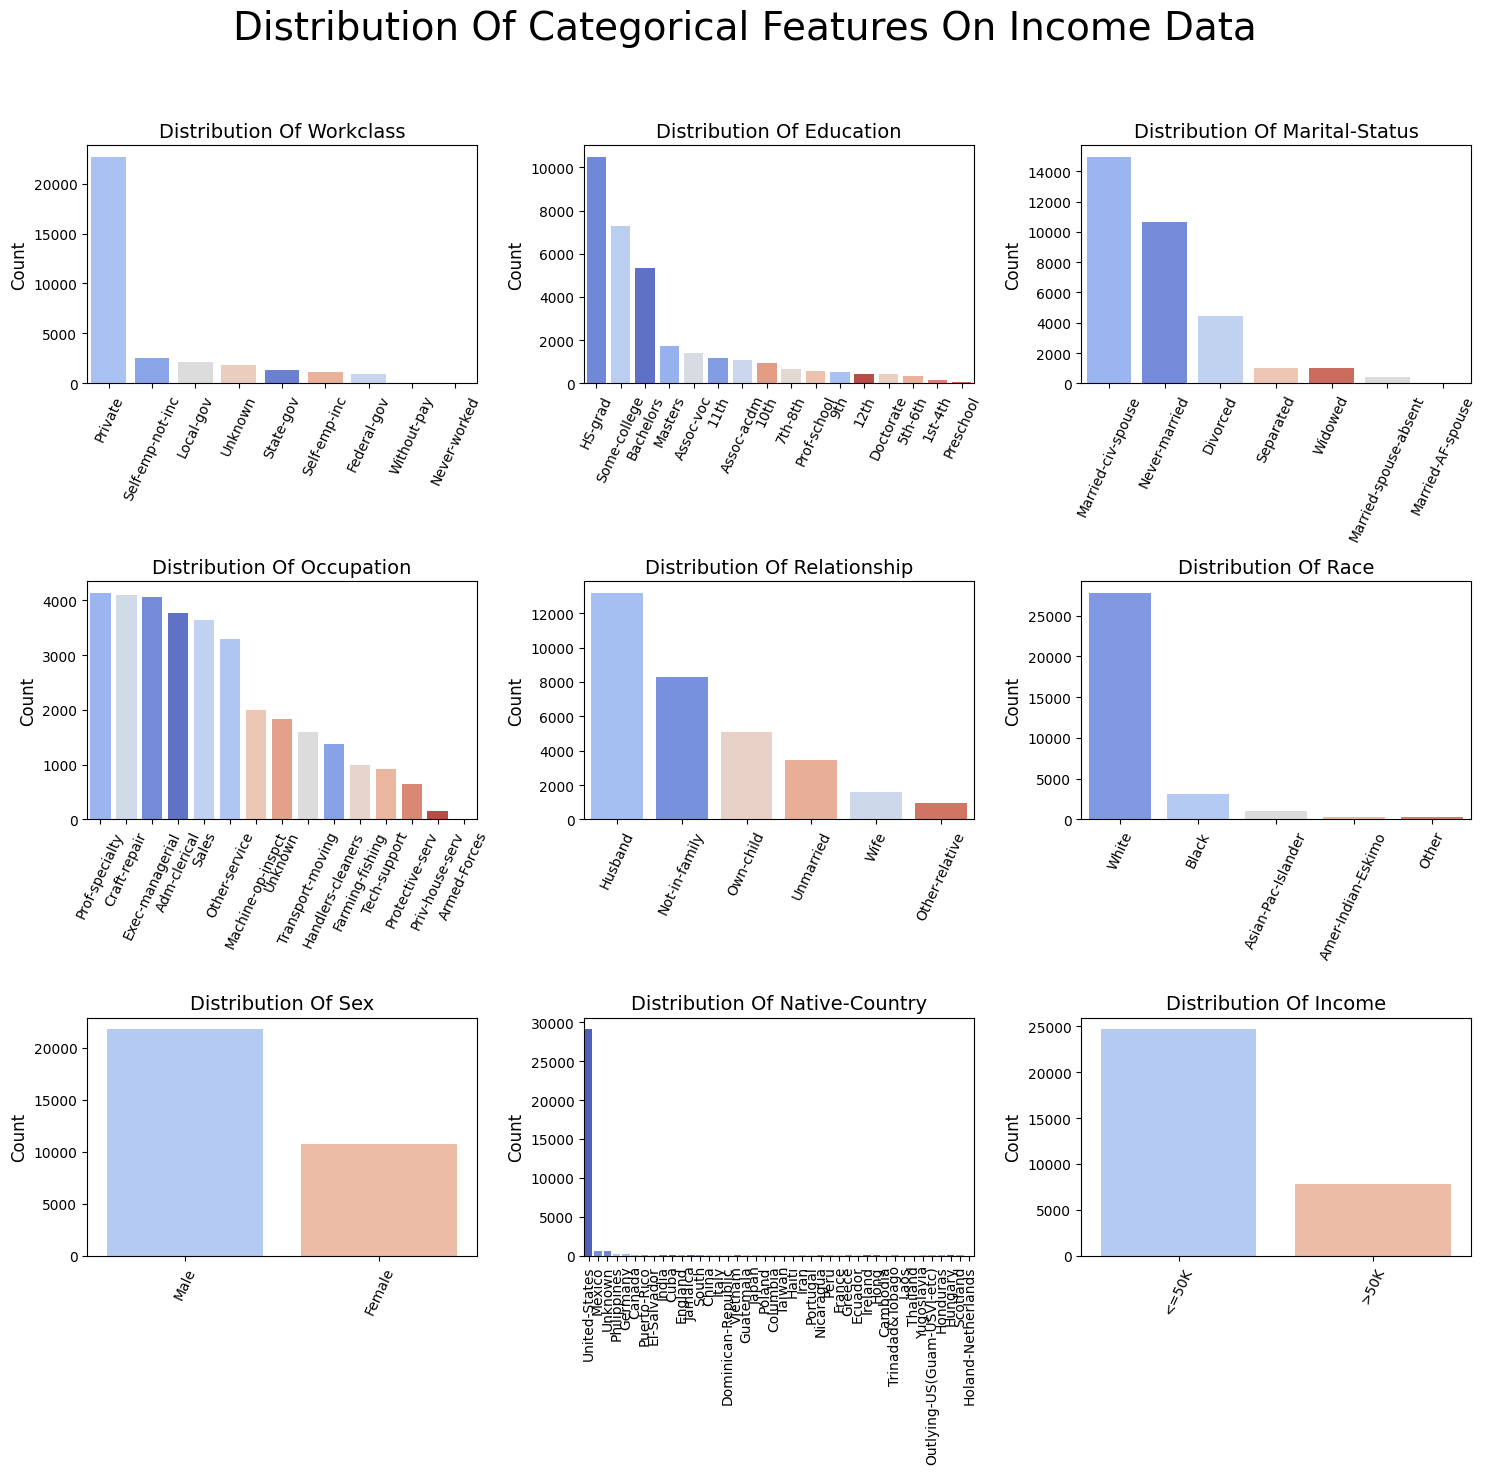

In [28]:
plot_categorical_features(
    data=income_data_obj,
    columns=income_data_obj.columns.to_list(),
    target_col='income',
    plot_type='countplot',
    y_axis_label='Count',
    subplot_title=[f'Distribution of {feature}' for feature in income_data_obj.columns.to_list()],
    main_title="Distribution of Categorical Features on Income Data",
    # order=income_data_obj[col].value_counts().index,
    palette='coolwarm'
)

In [ ]:
'''This code is Redentend'''
# num_cols = len(income_data_obj.columns)
# cols = 3
# rows = math.ceil(num_cols/cols)

# fig, axes = plt.subplots(rows, cols, figsize=(15, rows*5))
# axes = axes.flatten()
# for i, col in enumerate(income_data_obj.columns):
#     sns.countplot(
#         data=income_data_obj,
#         x=col,
#         order=income_data_obj[col].value_counts().index,
#         palette='coolwarm',
#         hue=col,
#         ax=axes[i]
#     )
    
#     axes[i].set_title(f'Distribution of {col}', fontsize=14)
#     if col == ' native-country':
#         axes[i].tick_params(axis='x', rotation=90)
#     else:
#         axes[i].tick_params(axis='x', rotation=65)
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('Count')

# # Turned off any unused subplot axes 
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# # Added over all title & adjest layout
# fig.suptitle("Distribution of Categorical Attributes on Income Data", fontsize=28)
# plt.tight_layout(rect=[0.0, 0.0, 1, 0.95])  # Adjust layout to fit title
# plt.show()

##### 3. Analysis by Target Column (income)

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

In [ ]:
'''Flag: This Function is not working properly here'''
# plot_categorical_features(
#     data=income_data_obj,
#     columns=income_data_obj.drop(columns='income').columns,
#     target_col='income',
#     plot_type='countplot',
#     y_axis_label='Count',
#     subplot_title=[f'{feature} vs income' for feature in income_data_obj.columns.to_list()],
#     main_title="categorical attribute vs income distribution",
#     # order=income_data_obj[col].value_counts().index,
#     palette='coolwarm'
# )

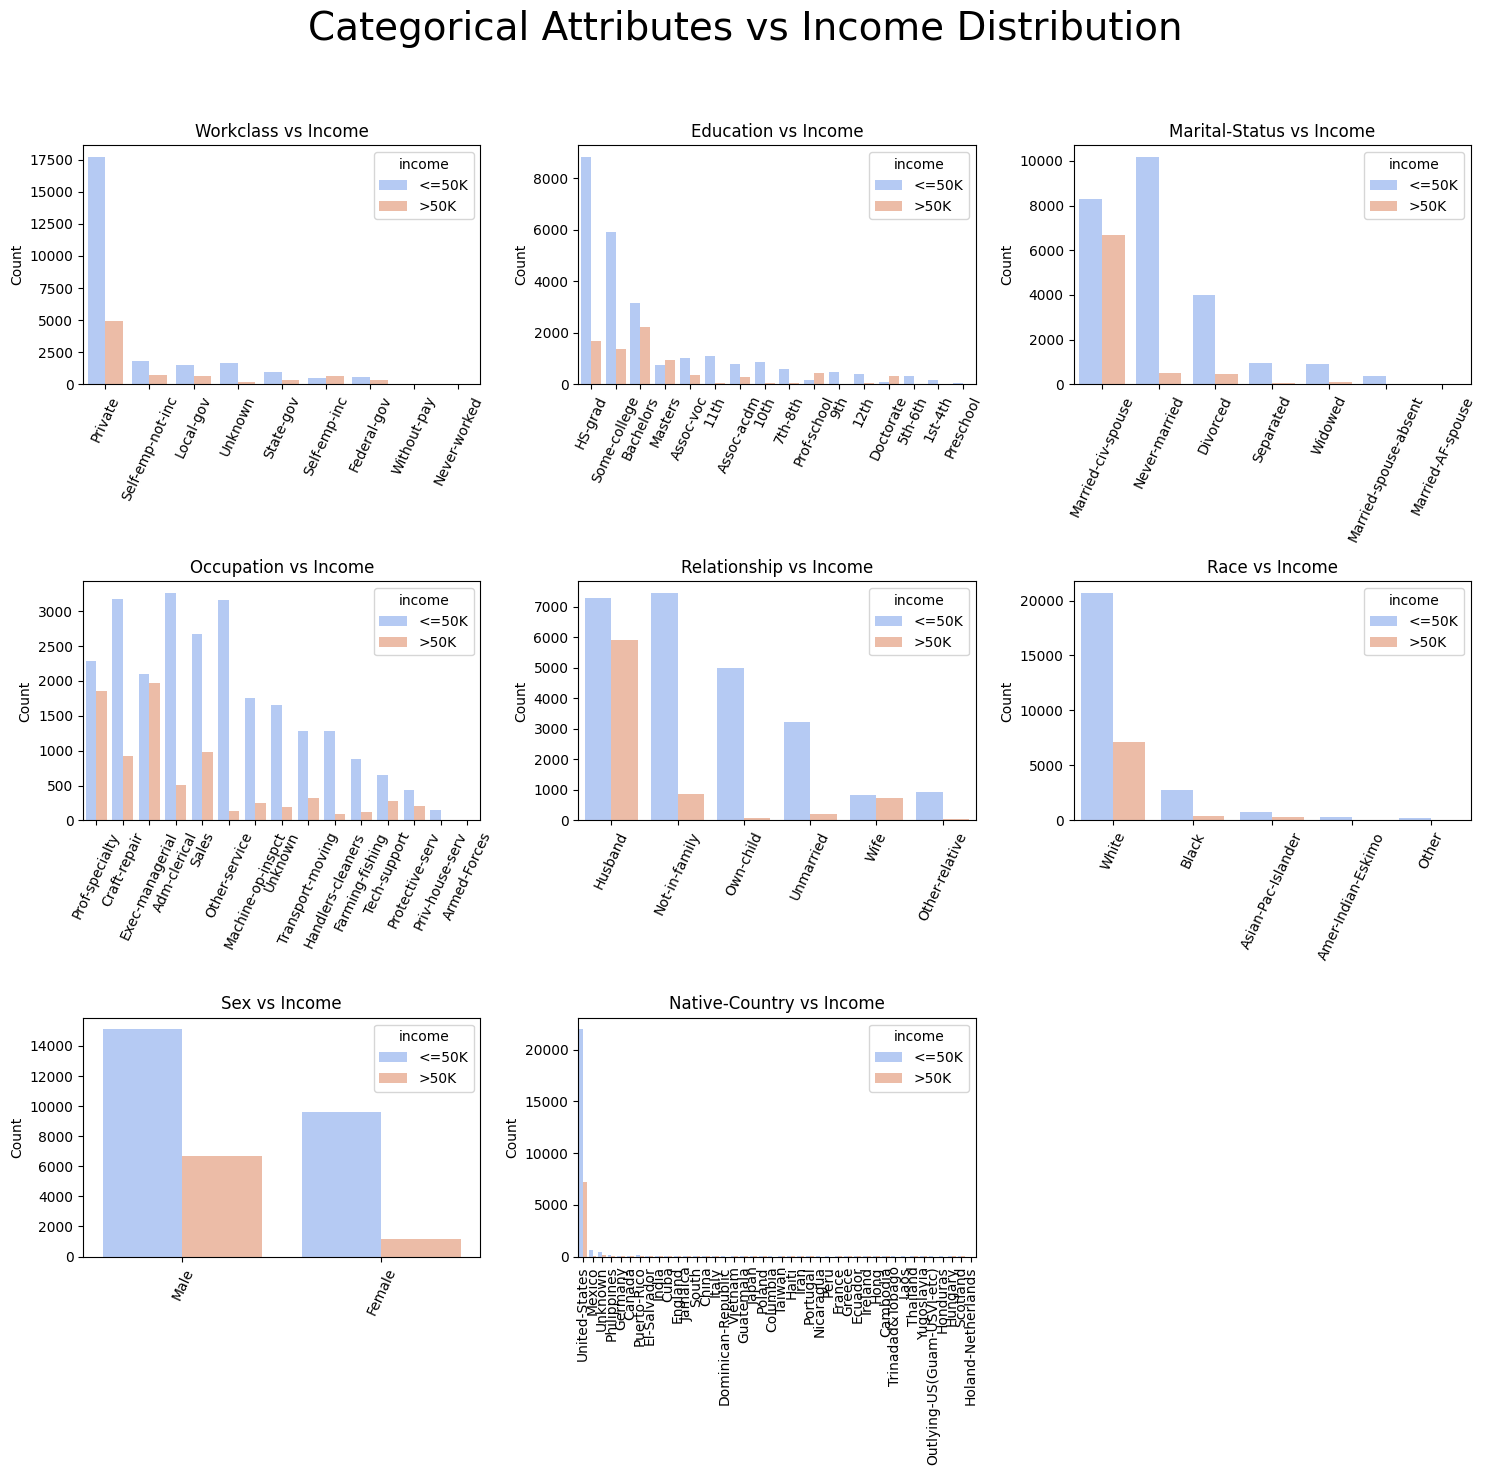

In [12]:
columns = income_data_obj.columns.tolist()
columns.remove('income')

num_cols = len(columns)
cols = 3
rows = math.ceil(num_cols/cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows*5))
axes = axes.flatten()
for i, col in enumerate(columns):
    sns.countplot(
        data=income_data_obj,
        x=col,
        hue='income',
        order=income_data_obj[col].value_counts().index,
        palette='coolwarm',
        ax=axes[i]
    )
    
    axes[i].set_title(f'{col.strip().title()} vs Income')
    if col == 'native-country':
        axes[i].tick_params(axis='x', rotation=90)
    else:
        axes[i].tick_params(axis='x', rotation=65)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    
# Turened off any unused subplot axis
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
fig.suptitle('Categorical Attributes vs Income Distribution', fontsize=28)
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])
plt.show()

#### 3. Correlations & Relationships
For *Correlations & Relationships* we perform `Chi-Square Test` that statictically check the relationships categorical features.

In [59]:
encoded_data = income_data_obj.copy()
label_encodes = {}

for feature in encoded_data.columns:
    le = LabelEncoder()
    encoded_data[feature] = le.fit_transform(encoded_data[feature])
    label_encodes[feature] = le #Save the encoder for inverse transformation (if needed)

# Split the data into features and target
X = encoded_data.drop(columns=['income']) # Features
y = encoded_data['income'] # Target

# Now apply Chi2 test
chi2_score, p_value = chi2(X, y)

chi2_result = pd.DataFrame({'Features': X.columns, 'Chi2 Score': chi2_score, 'p-value': p_value})
chi2_result.sort_values(by='Chi2 Score', ascending=False, inplace=True)
chi2_result.reset_index(drop=True, inplace=True)
chi2_result

,Features,Chi2 Score,p-value
0,relationship,3659.143125,0.000000e+00
1,marital-status,1123.469818,2.617595e-246
2,sex,502.439419,2.800299e-111
3,education,297.942270,9.248822e-67
4,workclass,47.246426,6.260002e-12
5,race,33.031305,9.068686e-09
6,native-country,17.363882,3.086357e-05
7,occupation,11.084991,8.702926e-04


In [28]:
# Select the best top 5 features
k_best = SelectKBest(score_func=chi2, k=5)
X_kbest = k_best.fit_transform(X, y)

# Get the name of the best 5 selected features
best_feature = X.columns[k_best.get_support()]
print('Top Features Based on Chi2 Test: ', best_feature.tolist())

Top Features Based on Chi2 Test:  [' workclass', ' education', ' marital-status', ' relationship', ' sex']


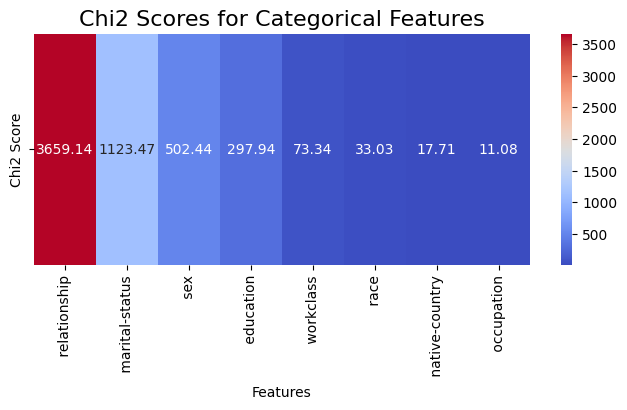

In [64]:
# Plotting the heatmap of Chi2 Scores
plt.figure(figsize=(8, 3))
sns.heatmap(chi2_result.drop(columns=['p-value']).set_index('Features').T, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Chi2 Scores for Categorical Features", fontsize=16)
plt.show()


### Continuting with Numerical Attributes

In [34]:
income_data_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   fnlwgt          32561 non-null  int64
 2   education-num   32561 non-null  int64
 3   capital-gain    32561 non-null  int64
 4   capital-loss    32561 non-null  int64
 5   hours-per-week  32561 non-null  int64
dtypes: int64(6)
memory usage: 1.5 MB


#### 1. Hendling Missing Values
Numerical Data contain no missing values.

In [35]:
income_data_int.isna().sum()

age               0
fnlwgt            0
education-num     0
capital-gain      0
capital-loss      0
hours-per-week    0
dtype: int64

In [36]:
income_data_int['income'] = income_data['income'].copy()

In [37]:
income_data_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   fnlwgt          32561 non-null  int64 
 2   education-num   32561 non-null  int64 
 3   capital-gain    32561 non-null  int64 
 4   capital-loss    32561 non-null  int64 
 5   hours-per-week  32561 non-null  int64 
 6   income          32561 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.7+ MB


In [87]:
# group_states = income_data_int.groupby([' income'])[[feature for feature in income_data_int.columns[:-1]]].describe()
# group_states

In [63]:
##Group by income and calculate descriptive statistics
grouped_stats = income_data_int.groupby('income')[[col for col in income_data_int.columns[:-1]]].describe()

# Reset index and flatten the MultiIndex for cleaner output
grouped_stats_flat = grouped_stats.stack().reset_index()

grouped_stats_flat.set_index(keys=['level_1'])


,income,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
level_1,,,,,,,
count,<=50K,24720.000000,2.472000e+04,24720.000000,24720.000000,24720.000000,24720.000000
mean,<=50K,36.783738,1.903409e+05,9.595065,148.752468,53.142921,38.840210
std,<=50K,14.020088,1.064823e+05,2.436147,963.139307,310.755769,12.318995
min,<=50K,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,<=50K,25.000000,1.176060e+05,9.000000,0.000000,0.000000,35.000000
50%,<=50K,34.000000,1.794650e+05,9.000000,0.000000,0.000000,40.000000
75%,<=50K,46.000000,2.390230e+05,10.000000,0.000000,0.000000,40.000000
max,<=50K,90.000000,1.484705e+06,16.000000,41310.000000,4356.000000,99.000000
count,>50K,7841.000000,7.841000e+03,7841.000000,7841.000000,7841.000000,7841.000000


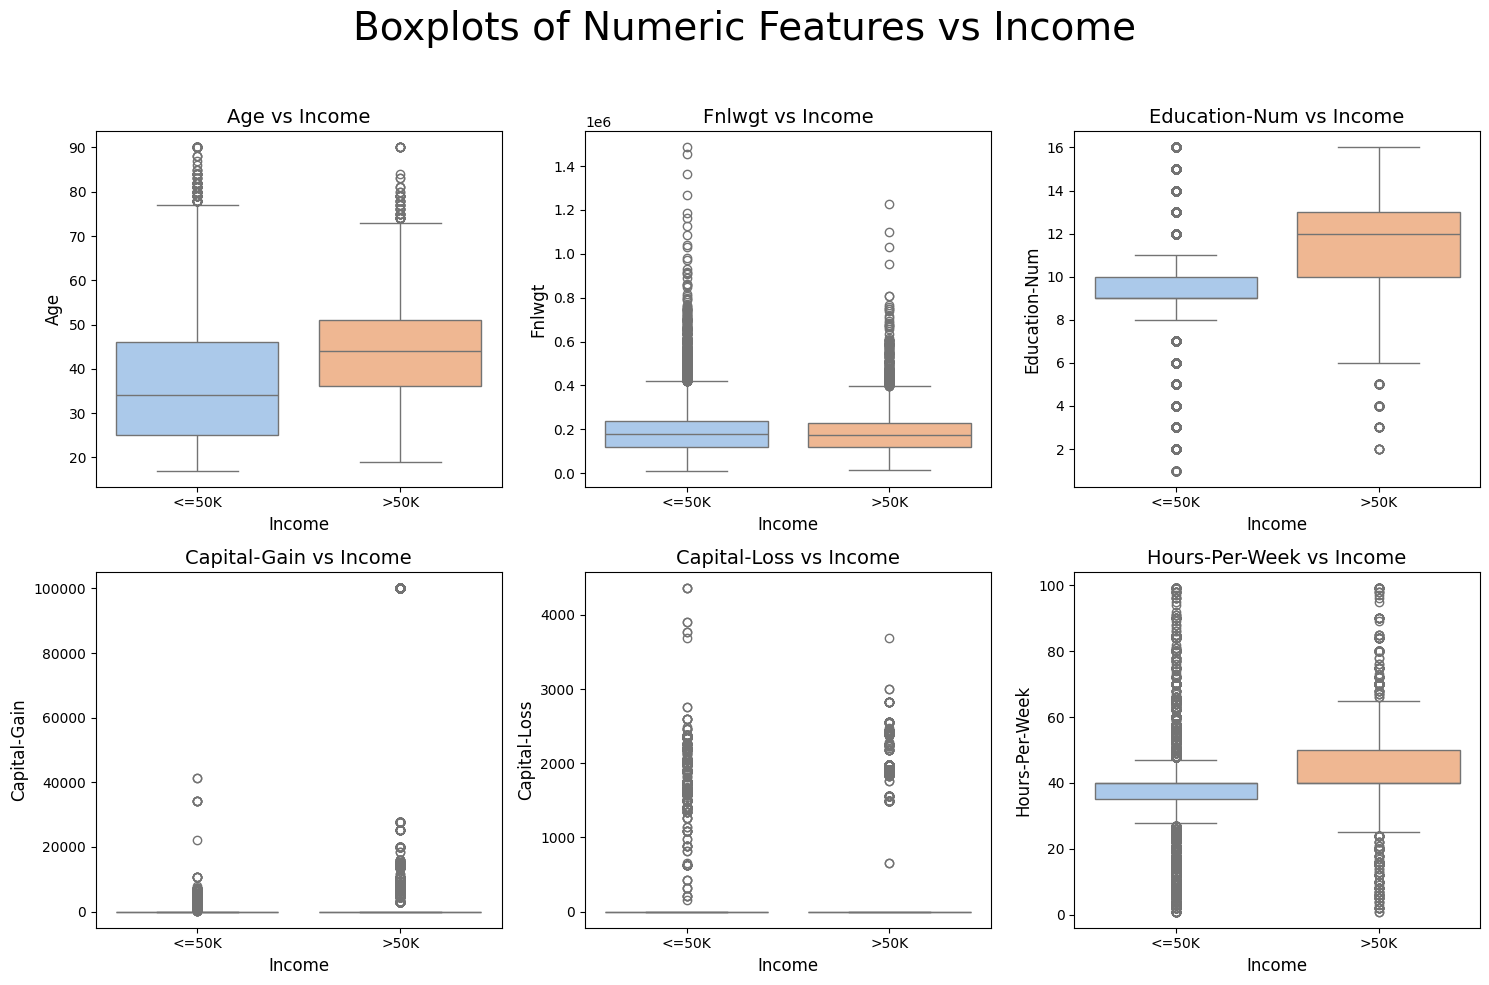

In [50]:
columns = income_data_int.columns[:-1]
num_cols = len(columns)
cols = 3
rows = math.ceil(num_cols/cols)

fig, ax = plt.subplots(rows, cols, figsize=(15, rows*5))
ax = ax.flatten()
for i, col in enumerate(columns):
    sns.boxplot(
        data=income_data_int,
        x='income',
        y=col,
        palette='pastel',
        hue='income',
        ax=ax[i]
    )
    
    ax[i].set_title(f'{col.title()} vs Income', fontsize=14, fontweight='light')
    ax[i].set_xlabel('Income', fontsize=12, fontweight='ultralight')
    ax[i].set_ylabel(col.title(), fontsize=12, fontweight='ultralight')
    # ax[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])
fig.suptitle('Boxplots of Numeric Features vs Income', fontsize=28, fontweight='normal')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])
plt.show()

In [ ]:
'''Flag: Function miss behaving'''
# plot_categorical_features(
#     data=income_data_obj,
#     columns=income_data_obj.drop(columns='income').columns,
#     target_col='income',
#     plot_type='boxplot',
#     y_axis_label=[f'{feature}' for feature in income_data_obj.drop(columns='income').columns.to_list()],
#     subplot_title=[f'{feature} vs Income' for feature in income_data_obj.drop(columns='income').columns.to_list()],
#     main_title="Boxplots of Numeric Features vs Income",
#     # order=income_data_obj[col].value_counts().index,
#     palette='coolwarm'
# )

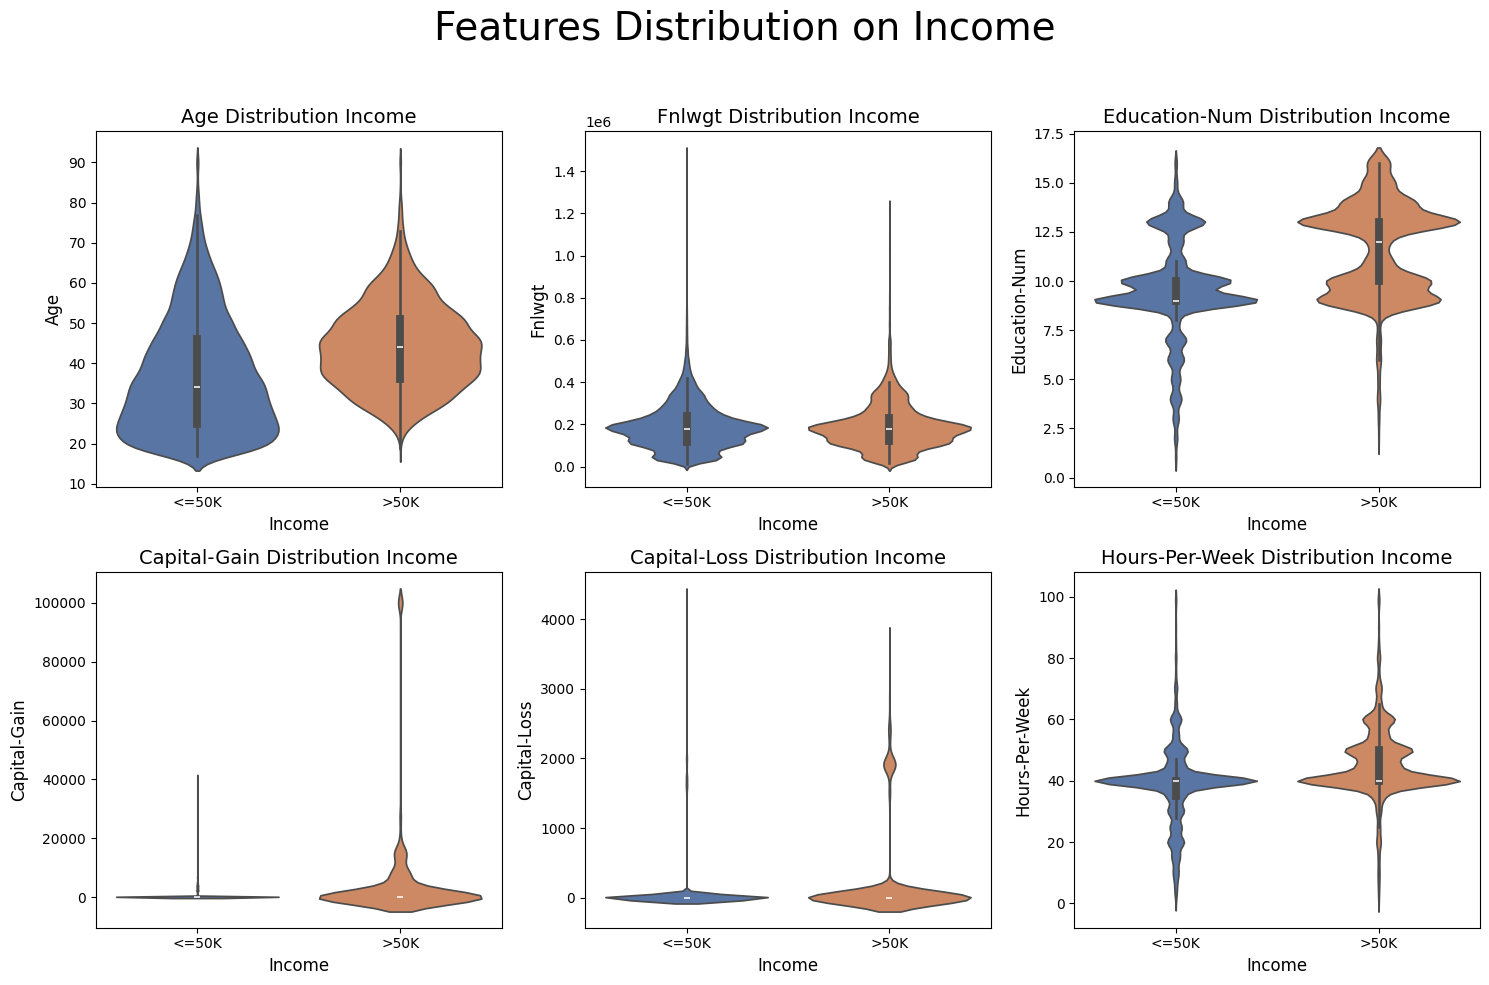

In [40]:
columns = income_data_int.columns[:-1]
num_cols = len(columns)
cols = 3
rows = math.ceil(num_cols/cols)

fig, ax = plt.subplots(rows, cols, figsize=(15, rows*5))
ax = ax.flatten()
for i, col in enumerate(columns):
    sns.violinplot(data=income_data_int,
                   x='income',
                   y=col,
                   hue='income',
                   ax=ax[i],
                   palette='deep')
    
    ax[i].set_title(f'{col.title()} Distribution Income', fontsize=14, fontweight='light')
    ax[i].set_xlabel('Income', fontsize=12, fontweight='ultralight')
    ax[i].set_ylabel(col.title(), fontsize=12, fontweight='ultralight')
    # ax[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])
fig.suptitle('Features Distribution on Income', fontsize=28, fontweight='normal')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])
plt.show()

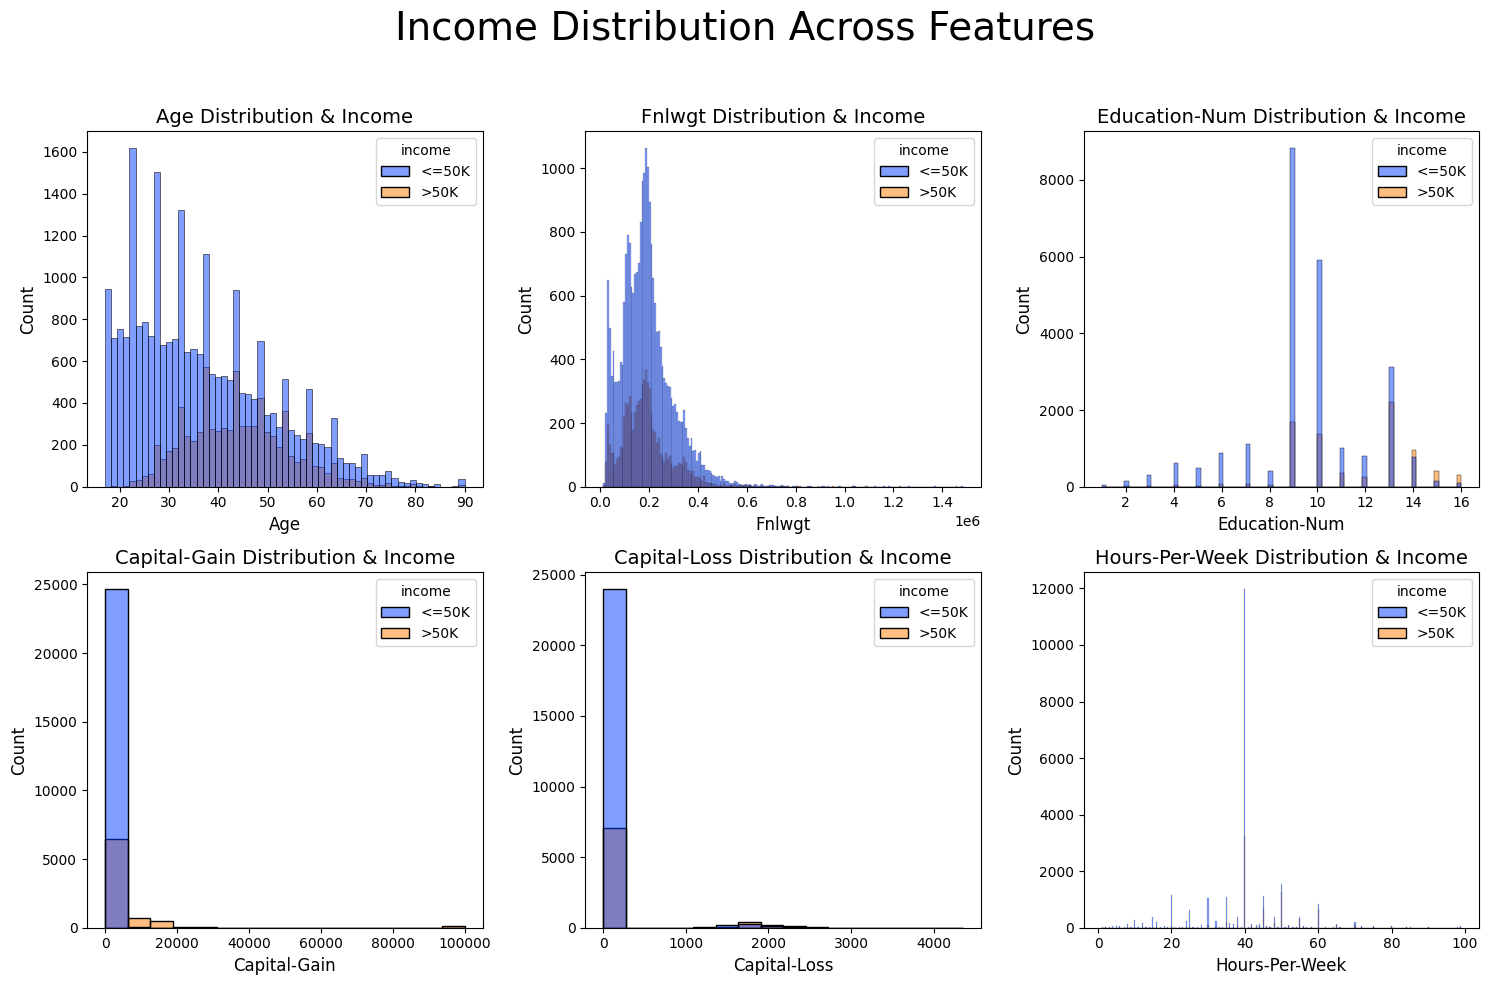

In [53]:
columns = income_data_int.columns[:-1]
num_cols = len(columns)
cols = 3
rows = math.ceil(num_cols/cols)

fig, ax = plt.subplots(rows, cols, figsize=(15, rows*5))
ax = ax.flatten()
for i, col in enumerate(columns):
    sns.histplot(data=income_data_int,
                   x=col,
                   hue='income',
                   ax=ax[i],
                   palette='bright')
    
    ax[i].set_title(f'{col.title()} Distribution & Income', fontsize=14, fontweight='light')
    ax[i].set_xlabel(col.title(), fontsize=12, fontweight='ultralight')
    ax[i].set_ylabel('Count', fontsize=12, fontweight='ultralight')
    # ax[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])
fig.suptitle('Income Distribution Across Features', fontsize=28, fontweight='normal')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])
plt.show()

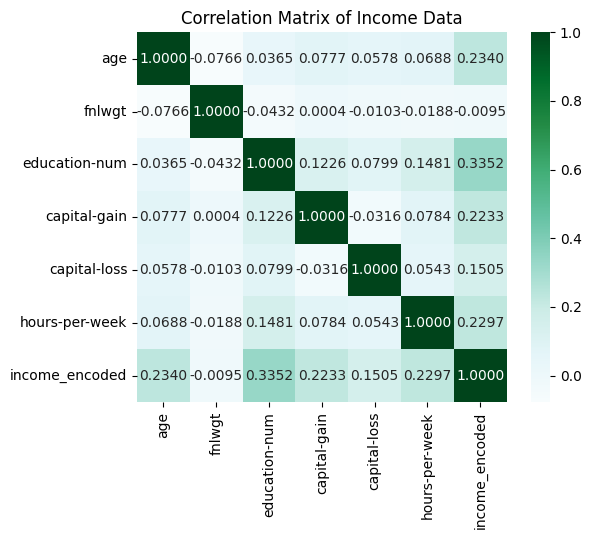

In [76]:
income_type_encoded = income_data_int['income'].value_counts().index.to_list()
income_type_encoded = {income_type_encoded[i]: i for i in range(len(income_type_encoded))}
income_data_int['income_encoded'] = income_data_int['income'].map(income_type_encoded)
income_corr_matrix = income_data_int[income_data_int.drop(columns=['income']).columns].corr()
sns.heatmap(income_corr_matrix, annot=True, cmap='BuGn', square=True, fmt='.4f')
plt.title('Correlation Matrix of Income Data')
plt.show()

In [78]:
income_data_int[income_data_int.drop(columns=['income']).columns].corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income_encoded
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
income_encoded,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000
